In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class SocialNavigationMetrics:
    def __init__(self, data):
        """
        Initializes the SocialNavigationMetrics with position data.

        Args:
            data (DataFrame): A pandas DataFrame containing 'human_x', 'human_y', 'human_z',
                              'wingman_x', 'wingman_y', 'wingman_z' columns with position
                              data for each frame.
        """
        self.data = data
    
    def calculate_metric(self, order):
        """
        Calculates the mean of the nth order derivative squared of the position data, 
        averaged over all frames. This is used to compute velocity (1st derivative), 
        acceleration (2nd derivative), and jerk (3rd derivative).

        Args:
            order (int): The order of the derivative (1 for velocity, 2 for acceleration, 3 for jerk).

        Returns:
            float: The mean of the squared values of the nth order derivative.
        """
        data_diff = self.data.diff(periods=order).fillna(0)
        squared_sums = (data_diff ** 2).sum(axis=1)
        mean_squared = squared_sums.mean()
        return mean_squared

    def minimum_distance(self):
        """
        Computes the minimum Euclidean distance between the 'human' and 'wingman' positions
        across all frames.

        Returns:
            float: The minimum distance found in the dataset.
        """
        distances = np.linalg.norm(self.data[['human_x', 'human_y', 'human_z']].to_numpy() - 
                                   self.data[['wingman_x', 'wingman_y', 'wingman_z']].to_numpy(), axis=1)
        return np.min(distances)

    def collision_risk(self, epsilon, t_critical):
        """
        Calculates the collision risk by counting the number of frames where the distance
        between the 'human' and 'wingman' is below a critical threshold (epsilon) or where
        the calculated Time to Reach (TTR) based on closing velocity is below a critical time (t_critical).

        Args:
            epsilon (float): Critical distance threshold to count as a collision risk.
            t_critical (float): Critical time threshold for the Time to Reach calculation.

        Returns:
            int: The total count of frames presenting a collision risk.
        """
        risk_count = 0
        positions = self.data[['human_x', 'human_y', 'human_z', 'wingman_x', 'wingman_y', 'wingman_z']].to_numpy()
        for t in range(1, len(positions)):
            r_t = positions[t, :3] - positions[t, 3:]
            d_t = np.linalg.norm(r_t)
            if d_t < epsilon:
                risk_count += 1
                continue
            v_t = positions[t, :3] - positions[t-1, :3] - (positions[t, 3:] - positions[t-1, 3:])
            v_close_t = np.dot(r_t, v_t) / d_t if d_t != 0 else 0
            if v_close_t > 0:
                ttr = d_t / v_close_t
                if ttr < t_critical:
                    risk_count += 1
        return risk_count


In [2]:
def generate_flight_path(start_pos, end_pos, num_points, curve=False):
    """
    Generates a 3D flight path between two points. The path can be linear or have a sinusoidal curvature
    in the y-dimension, which is useful for simulating more dynamic and realistic aircraft movements.

    Args:
        start_pos (list or tuple of float): The starting coordinates of the path in the format [x, y, z].
        end_pos (list or tuple of float): The ending coordinates of the path in the format [x, y, z].
        num_points (int): The number of points to generate along the path.
        curve (bool, optional): If True, the path in the y-dimension will follow a sinusoidal pattern
            between the start and end y-values. Defaults to False for a straight line path.

    Returns:
        np.ndarray: A numpy array of shape (num_points, 3), where each row represents the [x, y, z]
            coordinates of a point along the path. The array is used to populate the DataFrame for
            simulation or visualization purposes.
    """
    x = np.linspace(start_pos[0], end_pos[0], num_points)
    if curve:
        # Create a sinusoidal curve in the y-coordinate between start and end positions
        y = np.sin(np.linspace(0, np.pi, num_points)) * (end_pos[1] - start_pos[1]) / 2 + (start_pos[1] + end_pos[1]) / 2
    else:
        # Generate a linear interpolation between the start and end y-values
        y = np.linspace(start_pos[1], end_pos[1], num_points)
    z = np.linspace(start_pos[2], end_pos[2], num_points)
    return np.column_stack((x, y, z))

def plot_3d_trajectories(df, title='3D Trajectories of Aircrafts', labels=None, styles=None):
    """
    Plots 3D trajectories for multiple paths defined in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the x, y, z coordinates for each path.
                           Columns should be named as 'path1_x', 'path1_y', 'path1_z', 'path2_x', etc.
        title (str): Title of the plot.
        labels (list of str): Labels for each path, matching the order of path columns in df.
        styles (list of dict): List of style dictionaries to apply to each path plot. Each dictionary
                               can include matplotlib line plot keywords like 'color', 'marker', etc.

    """
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    num_paths = len(df.columns) // 3
    if labels is None:
        labels = ['Path {}'.format(i + 1) for i in range(num_paths)]
    if styles is None:
        styles = [{}] * num_paths  # Default empty style

    for i in range(num_paths):
        x_col, y_col, z_col = df.columns[3*i:3*i+3]
        ax.plot(df[x_col], df[y_col], df[z_col], label=labels[i], **styles[i])

    ax.set_title(title)
    ax.set_xlabel('X Position (m)')
    ax.set_ylabel('Y Position (m)')
    ax.set_zlabel('Z Position (m)')
    ax.legend()
    plt.show()

Velocity (M1): 75.1884309142626
Acceleration (M2): 295.5333234385787
Jerk (M3): 653.1986903514367
Minimum Distance (M4): 9.999999999999996
Collision Risk (M5): 1


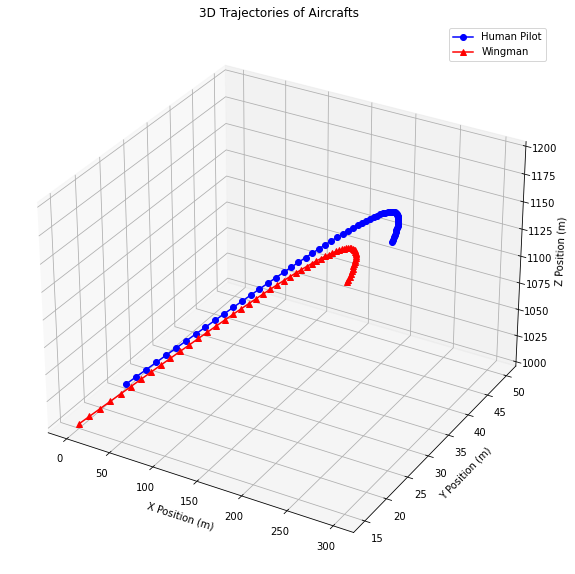

In [3]:
# Example of generating a sample DataFrame with realistic aircraft positions
num_points = 60
human_path = generate_flight_path([0, 0, 1000], [300, 50, 1200], num_points, curve=True)
wingman_path = generate_flight_path([0, -10, 1000], [300, 40, 1200], num_points, curve=True)

data = {
    'human_x': human_path[:, 0],
    'human_y': human_path[:, 1],
    'human_z': human_path[:, 2],
    'wingman_x': wingman_path[:, 0],
    'wingman_y': wingman_path[:, 1],
    'wingman_z': wingman_path[:, 2]
}
df = pd.DataFrame(data)

metrics = SocialNavigationMetrics(df)
print("Velocity (M1):", metrics.calculate_metric(1))  # meters per second
print("Acceleration (M2):", metrics.calculate_metric(2))  # meters per second squared
print("Jerk (M3):", metrics.calculate_metric(3))  # meters per second cubed
print("Minimum Distance (M4):", metrics.minimum_distance())  # meters
print("Collision Risk (M5):", metrics.collision_risk(10, 5))  # frames at risk

# Plotting with custom labels and styles
plot_3d_trajectories(df, labels=['Human Pilot', 'Wingman'], 
                     styles=[{'color': 'blue', 'marker': 'o'}, {'color': 'red', 'marker': '^'}])